# Init Bionic VTOL

In [1]:
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using TensorBoardLogger
using Logging


using JLD;
using BSON: @save, @load # save mode

In [2]:
# TODO: set as desired
R_TOL = 0.5;
N_WAYPOINTS = 2; # including startpoint, >= 2
SLOW_MODE = true;
TRAINING = true;
EVALUATION = true;
TRAJECTORY = generate_trajectory(N_WAYPOINTS + 1)

3-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0]
 [-2.5932652423671767, 0.21430435204962306, 1.1493848289172468]
 [-4.0092555753711085, 0.7541161407736685, 2.8694886032128837]

In [3]:
create_visualization();

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


In [4]:
# TensorBoard
logger = TBLogger("tensorboard_PPO", tb_increment)

TBLogger:
	- Log level     : Info
	- Current step  : 0
	- Output        : /home/larissa/Documents/Projects/ADLR/ADLR_project/src/3d/tensorboard_PPO
	- open files    : 1


In [5]:
# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()

1

In [6]:
Δt = 0.025;

# Create Reinforcement Learning Environment

In [7]:
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv # Parametric Constructor for a subtype of AbstractEnv
    action_space::A # All possible actions the agent can take
    observation_space::Space{Vector{ClosedInterval{T}}} # All possible states that the agent can observe.
    state::Vector{T} # Current state
    action::ACT # next action the agent wants to apply in the environment.
    done::Bool # shows whether a terminal condition has been reached.
    t::T # time
    rng::R # random number generator

    name::String # for different naming of multible environoments
    visualization::Bool # activate visualisation (Faster computation without visualisation)
    realtime::Bool # visualization in "real-world" time (only for watching or filming).
    
    # Overall state of the environment. This does not correspond to the observation space of the agent but contains all states that describe the environment.
    x_W::Vector{T} # Position in World frame
    v_B::Vector{T} # Velocity in Body frame
    R_W::Matrix{T} # Rotation (matrix) in World frame
    ω_B::Vector{T} # Rotation velocity in Body frame
    wind_W::Vector{T} # Externel linear velocity acting on the drone
    Δt::T # Time step for physics simulation in seconds

    ###NEW###
    # Current Bonus / Target
    num_waypoints::Int # includig start point
    waypoints::Vector{Vector{T}}
    reached_goal::BitVector
    
    norm_way::T
    progress::T
    progress_prev::T
    current_point::Int
    reached_goal_in_step::Bool
    
    r_tol::T
    projected_position::Vector{T}

    slow_mode::Bool
    ######
end

In [8]:
# define a keyword-based constructor for the type declared in the mutable struct typedef. 
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
    rng = Random.GLOBAL_RNG, # Random number generation
    name = "Crazyflie",
    visualization = false,
    realtime = false,
    kwargs... # let the function take an arbitrary number of keyword arguments
)
    
    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.
    
    # final PWM Values for Crazyflie. The interval definition has no effect in the current implementation.
    action_space = Space(
        ClosedInterval{T}[
            0..1#0..65535, # motor 1
            0..1#0..65535, # motor 2
            0..1#0..65535, # motor 3
            0..1#0..65535, # motor 4
            ], 
    )

    
    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[#todo
            typemin(T)..typemax(T), # 1 x
            typemin(T)..typemax(T), # 2 y
            typemin(T)..typemax(T), # 3 z

            typemin(T)..typemax(T), # 4  World Vector UP x
            typemin(T)..typemax(T), # 5  World Vector UP y
            typemin(T)..typemax(T), # 6  World Vector UP z

            typemin(T)..typemax(T), # 7  World Vector FRONT x
            typemin(T)..typemax(T), # 8  World Vector FRONT y
            typemin(T)..typemax(T), # 9  World Vector FRONT z
            
            typemin(T)..typemax(T), # 10 Body velocity along x
            typemin(T)..typemax(T), # 11 Body velocity along y
            typemin(T)..typemax(T), # 12 Body velocity along z
            
            typemin(T)..typemax(T), # 13 Body rotational velocity around x
            typemin(T)..typemax(T), # 14 Body rotational velocity around y
            typemin(T)..typemax(T), # 15 Body rotational velocity around z
            
            ###NEW###
            typemin(T)..typemax(T), # 16 position error along x (next gate - current position)
            typemin(T)..typemax(T), # 17 position error along y (next gate - current position)
            typemin(T)..typemax(T), # 18 position error along z (next gate - current position)
            
            typemin(T)..typemax(T), # 19 way to next next gate x (next next gate - next gate)
            typemin(T)..typemax(T), # 20 way to next next gate y (next next gate - next gate)
            typemin(T)..typemax(T), # 21 way to next next gate z (next next gate - next gate)
            ######
            ], 
    )

    ###NEW###
    num_waypoints = N_WAYPOINTS # number of waypoints, includig start point
    waypoints = generate_trajectory(num_waypoints + 1) # trajectory with num_waypoints waypoints (+ start point), (with dummy points) 
    reached_goal = falses(num_waypoints)
    
    norm_way = 0.0 
    for i in 1:(num_waypoints - 1)
        norm_way += norm(waypoints[i] - waypoints[i + 1])
    end
    ######
    
    if visualization
        create_Crazyflie(name, actuators = true);
        visualize_waypoints(waypoints[1:num_waypoints], 0.05)

        set_Crazyflie_actuators(name, [0.0; 0.0; 0.0; 0.0]);
        set_transform(name, [0.0; 0.0; 0.0] ,one(QuatRotation));
        set_arrow(string(name, "vel"), color_vec=[0.0; 1.0; 0.0; 1.0]);
        transform_arrow(string(name, "vel"), [0.0; 0.0; 0.0], [0.0; 0.0; 1.0], max_head_radius=0.05)
#         set_arrow(string(name, "_vel_current"), color_vec=[1.0; 0.0; 0.0; 1.0]);
#         transform_arrow(string(name, "_vel_current"), [0.0; 0.0; 0.0], [0.0; 0.0; 1.0], max_head_radius=0.02)                  
    end
    


    environment = VtolEnv(
        action_space,
        state_space,
        zeros(T, length(state_space)), # current state, needs to be extended.
        [0.25; 0.25; 0.25; 0.25],#rand(action_space), #todo test with random
        false, # episode done ?
        0.0, # time
        rng, # random number generator  

        name,
        visualization,
        realtime,

        zeros(T, 3), # x_W
        zeros(T, 3), # v_B
        Matrix(one(QuatRotation)), # Float64... so T needs to be Float64
        zeros(T, 3), # ω_B
        zeros(T, 3), # wind_W
        Δt, # Δt

        num_waypoints, # includig start point
        waypoints, 
        reached_goal,

        norm_way, # norm_way
        0.0, # progress
        0.0, # progress_prev
        2, # current point
        false, # reached_goal_in_step
        
        R_TOL, # r_tol
        zeros(T, 3), # projected_position

        SLOW_MODE # slow_mode

        )
    
    
    RLBase.reset!(environment)
    
    return environment
    
end;

Just for explanation:

1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.

So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

In [9]:
methods(VtolEnv)

# 2 methods for type constructor:
[1] VtolEnv(; rng, name, visualization, realtime, kwargs...) in Main at In[8]:3
[2] VtolEnv(action_space::A, observation_space::Space{Array{ClosedInterval{T}, 1}}, state::Vector{T}, action::ACT, done::Bool, t::T, rng::R, name::String, visualization::Bool, realtime::Bool, x_W::Vector{T}, v_B::Vector{T}, R_W::Matrix{T}, ω_B::Vector{T}, wind_W::Vector{T}, Δt::T, num_waypoints::Int64, waypoints::Array{Vector{T}, 1}, reached_goal::BitVector, norm_way::T, progress::T, progress_prev::T, current_point::Int64, reached_goal_in_step::Bool, r_tol::T, projected_position::Vector{T}, slow_mode::Bool) where {A, T, ACT, R<:AbstractRNG} in Main at In[7]:2

# Define the RL interface

In [10]:
Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

In [11]:
function scale_for_slowmode(slow_mode::Bool, v_min::T, v_max::T, d_max::T, x_W::Vector{T}, projected_position::Vector{T}, v_B::Vector{T}) where T
    
    if slow_mode == false
        return 1
    else
        if norm(v_B) > v_max
            s_vmax = 10^(v_max - norm(v_B))
        else
            s_vmax = 1
        end

        if norm(v_B) < v_min
            s_vmin = 10^(norm(v_B) - v_min)
        else
            s_vmin = 1
        end

        if norm(x_W - projected_position) > d_max
            s_gd = exp(-norm(x_W - projected_position) + d_max)
        else
            s_gd = 1
        end
        s = s_vmax * s_vmin * s_gd
    end
    return s
end;

In [12]:
function computeReward(env::VtolEnv{A,T}) where {A,T}
    
    
    if env.slow_mode
        v_min = 1.0 # min velocity
        v_max = 3.0 # max velocity
        d_max = 0.5 
    else
        v_min = 4.0 # min velocity
        v_max = 50.0 # max velocity
        d_max = 1.0 
    end


    s = scale_for_slowmode(true, v_min, v_max, d_max, env.x_W, env.projected_position, env.v_B)
    
    # TODO: test norming
    k_p = 5.0 * s #/ env.norm_way # factor for progress (between current position and last position) reward 
    r_p = (env.progress - env.progress_prev); # reward for progress (between current position and last position)

    k_s = s * (2 * v_max * env.Δt) / env.norm_way # factor for reached distance (overall) reward
    r_s = env.progress # reward for reached distance (overall)
    
    k_wp = 50.0 # factor for reached gate reward
    r_wp = 0.0 # reward for reached gate
    if env.reached_goal_in_step
        r_wp = exp(-norm(env.x_W - env.waypoints[env.current_point - 1])/env.r_tol)
    end 

    # factor for too high body rate penalty
    if env.slow_mode
        k_ω = 0.01
    else
        k_ω = 0.001
    end
    #norm_ω = norm(env.ω_B[3]) # penalty for body rate
    norm_ω = norm(env.ω_B) # penalty for body rate

    if env.x_W[3] < 0
        fall = 1
    else
        fall = 0
    end
    
    if !env.slow_mode
        k_s /= env.norm_way
        k_p /= env.norm_way
    end
    
    return k_p * r_p + k_s * r_s + k_wp * r_wp - k_ω * norm_ω - fall
    
end


RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

In [13]:
function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    
    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = [0.0; 0.0; 0.0];
    env.R_W = Matrix(one(QuatRotation)); # Identity matrix (no rotation)
    env.ω_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];


    env.waypoints = generate_trajectory(env.num_waypoints + 1); # Dummy points
    env.reached_goal = falses(env.num_waypoints);
    env.reached_goal[1] = true; # set first point to reached (start point)
    
    env.current_point = 2;
    env.reached_goal_in_step = false;
    #env.r_tol = 0.3;
    
    if env.visualization
        visualize_waypoints(env.waypoints[1:env.num_waypoints], 0.05); 
    end
    
    norm_way = 0.0 
    for i in 1:(env.num_waypoints - 1)
        norm_way += norm(env.waypoints[i] - env.waypoints[i + 1])
    end
    
    env.norm_way = norm_way
    env.progress = 0.0;
    env.progress_prev = 0.0;
        
 #todo
    env.state = [env.x_W[1]; # 1 position along x
                 env.x_W[2]; # 2 position along y
                 env.x_W[3]; # 3 position along z
#todo right R_W?
                 env.R_W[1,1];
                 env.R_W[2,1];
                 env.R_W[3,1];
        
                 env.R_W[1,3]; # 4  World Vector UP x
                 env.R_W[2,3]; # 5  World Vector UP y
                 env.R_W[3,3]; # 6  World Vector UP z

#                  env.R_W[1,1]; # 7  World Vector FRONT x
#                  env.R_W[2,1]; # 8  World Vector FRONT y
#                  env.R_W[3,1]; # 9  World Vector FRONT z

                 env.v_B[1]; #  10 Body velocity along x
                 env.v_B[2]; #  11 Body velocity along y
                 env.v_B[3]; #  12 Body velocity along z

                 env.ω_B[1]; #  13  Body rotational velocity around x
                 env.ω_B[2]; #  14  Body rotational velocity around y
                 env.ω_B[3]; #  15  Body rotational velocity around z

                 env.waypoints[2][1] - env.x_W[1]; # 16 position error to next gate along x
                 env.waypoints[2][2] - env.x_W[2]; # 17 position error to next gate along z
                 env.waypoints[2][3] - env.x_W[3]; # 18 position error to next gate along z
                 
                 env.waypoints[3][1] - env.waypoints[2][1]; # 19 way to next next gate x 
                 env.waypoints[3][2] - env.waypoints[2][2]; # 20 way to next next gate y
                 env.waypoints[3][3] - env.waypoints[2][3]]  # 21 way to next next gate z 
    

    env.t = 0.0; # time 0s
    env.action = [0.25; 0.25; 0.25; 0.25] # normalized # todo try with 0.0
    #env.last_action = [0.255; 0.255; 0.255; 0.255] # normalized
    #env.current_action = [0.255; 0.255; 0.255; 0.255] # normalized

    env.done = false # reset termination

    env.projected_position = [0; 0; 0]
    
    if env.visualization
        # Visualize initial state
        set_transform(env.name, env.x_W,QuatRotation(env.R_W));
        set_Crazyflie_actuators(env.name, [0.0; 0.0; 0.0; 0.0]);
        #transform_arrow(string(env.name, "_vel"), env.x_W, env.v_W_target, max_head_radius=0.05) 
        transform_arrow(string(env.name, "vel"), env.x_W, [0.0; 0.0; 0.0], max_head_radius=0.05) 
    end
    
    nothing # return nothing
end;

In [14]:
# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)


    # call the step on the environoment with the next action 
    _step!(env, a)
        
end

In [15]:
env = VtolEnv();

In [16]:
methods(env) # Just to explain which methods the object has

# 3 methods for callable object:
[1] (env::VtolEnv)(a) in Main at In[14]:3
[2] (env::AbstractEnv)(action) in ReinforcementLearningBase
[3] (env::AbstractEnv)(action, player) in ReinforcementLearningBase

In [17]:
function scale_actions(next_action)
    return next_action*22000.0
end

scale_actions (generic function with 1 method)

In [18]:
function _step!(env::VtolEnv, next_action)
    

    #env.last_action = copy(env.current_action)
    #env.current_action[1] = next_action[1]
    #env.current_action[2] = next_action[2]
    #env.current_action[3] = next_action[3]
    #env.current_action[4] = next_action[4]
    
    
    
    scaled_actions = scale_actions.(next_action) # between 0 and 1 for neual network
    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W)
    # caluclate aerodynamic forces
    torque_B, force_B = crazyflie_model(scaled_actions);
    # integrate rigid body dynamics for Δt
    env.x_W, env.v_B, env.R_W, env.ω_B, env.t = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.ω_B, env.t, env.Δt, crazyflie_param)

    
    env.reached_goal_in_step = false;
    if norm(env.x_W - env.waypoints[env.current_point]) < env.r_tol
        env.reached_goal_in_step = true;
        env.reached_goal[env.current_point] = true;
        env.current_point += 1;
    end
        
            
    # calculate progress on trajectory
    env.progress_prev = env.progress
    
    current_progress = 0.0
    line_segment, env.projected_position = calculate_progress(env.waypoints, env.x_W)
    
    #env.current_point = line_segment + 1

    for i in 2:(line_segment)
       current_progress +=  norm(env.waypoints[i] - env.waypoints[i - 1])  
    end
    current_progress += norm(env.waypoints[line_segment] - env.projected_position)
    
    env.progress = current_progress
    

    if env.realtime
        sleep(env.Δt) # TODO: just a dirty hack. this is of course slower than real time.
    end

    env.t += env.Δt


    if env.visualization
        set_transform(env.name, env.x_W,QuatRotation(env.R_W));
        set_Crazyflie_actuators(env.name, next_action[1:4])
        #transform_arrow(string(env.name, "_vel"), env.x_W, env.v_W_target, max_head_radius=0.05)               
        transform_arrow(string(env.name, "vel"), env.x_W, env.R_W*env.v_B, max_head_radius=0.05) 
    
        for i in eachindex(env.reached_goal)
            if env.reached_goal[i]
                create_sphere("fixgoal_$i", 0.05, color=RGBA{Float32}(1.0, 0.0, 0.0, 1.0));
                set_transform("fixgoal_$i", env.waypoints[i]);
            end
        end

    end
    
    
    #v_B_target = transpose(env.R_W)*env.v_W_target
    
    
    # State space
    #todo
    env.state[1] = env.x_W[1];
    env.state[2] = env.x_W[2];
    env.state[3] = env.x_W[3];
    
    env.state[4] = env.R_W[1,1] # 1  World Vector UP x
    env.state[5] = env.R_W[2,1] # 2  World Vector UP y
    env.state[6] = env.R_W[3,1] # 3  World Vector UP z

    env.state[7] = env.R_W[1,3] # 4  World Vector FRONT x
    env.state[8] = env.R_W[2,3] # 5  World Vector FRONT y
    env.state[9] = env.R_W[3,3] # 6  World Vector FRONT z
        
    env.state[10] = env.v_B[1] # 7  Body velocity along x
    env.state[11] = env.v_B[2] # 8  Body velocity along y
    env.state[12] = env.v_B[3] # 9  Body velocity along z

    env.state[13] = env.ω_B[1] # 10 Body rotational velocity around x
    env.state[14] = env.ω_B[2] # 11 Body rotational velocity around y
    env.state[15] = env.ω_B[3] # 12 Body rotational velocity around z

    env.state[16] = env.waypoints[env.current_point][1] - env.x_W[1] # 13 position error to next gate along x
    env.state[17] = env.waypoints[env.current_point][2] - env.x_W[2]; # 14 position error to next gate along z
    env.state[18] = env.waypoints[env.current_point][3] - env.x_W[3]; # 15 position error to next gate along z
     #todo            
    if env.current_point <= env.num_waypoints
        env.state[19] = env.waypoints[env.current_point + 1][1] - env.waypoints[env.current_point][1] ; # 16 way to next next gate x (next next gate - next gate), dummy integriert
        env.state[20] = env.waypoints[env.current_point + 1][2] - env.waypoints[env.current_point][2]; # 17 way to next next gate y (next next gate - next gate), dummy integriert
        env.state[21] = env.waypoints[env.current_point + 1][3] - env.waypoints[env.current_point][3]; # 18 way to next next gate z (next next gate - next gate), dummy integriert
    end

    
    
    # Termination criteria
    env.done = #true
        # After time... How fast is drone+Range of desired point
        # After reaching position (circle of r_tol)
         norm(env.ω_B) > 100.0 || 
         norm(env.v_B) > 100.0 || # stop if body is too fast_point 
        env.x_W[3] < -1.0 || # stop if body is below -5m
        env.t > env.num_waypoints * 3.0 ||# stop after 3s per point #todo set in fast learning phase
        norm(env.x_W - env.projected_position) > 5.0 || # too far off the path 
        env.reached_goal == trues(env.num_waypoints)

    nothing
end;

In [19]:
RLBase.test_runnable!(env)

Test Summary:              | Pass  Total  Time
random policy with VtolEnv | 2000   2000  2.1s


Test.DefaultTestSet("random policy with VtolEnv", Any[], 2000, false, false, true, 1.675700059788594e9, 1.675700061925892e9)

Show an overview of the environment.

# Setup of a reinforcement learning experiment.

In [20]:
seed = 123    
rng = StableRNG(seed)
N_ENV = 8
UPDATE_FREQ = 1024
    
    
    # define multiple environments for parallel training
    env = MultiThreadEnv([
        # use different names for the visualization
        VtolEnv(; rng = StableRNG(hash(seed+i)), name = "cf_PPO$i") for i in 1:N_ENV
    ])



MultiThreadEnv(8 x VtolEnv)

In [21]:
# Define the function approximator
    ns, na = length(state(env[1])), length(action_space(env[1]))
    approximator = ActorCritic(
                actor = GaussianNetwork(
                    pre = Chain(
                    Dense(ns, 256, tanh; initW = glorot_uniform(rng)),
                    Dense(256, 256, tanh; initW = glorot_uniform(rng)),
                    ),
                    μ = Chain(Dense(256, na; initW = glorot_uniform(rng))),
                    logσ = Chain(Dense(256, na; initW = glorot_uniform(rng))),
                ),
                critic = Chain(
                    Dense(ns, 256, tanh; initW = glorot_uniform(rng)),
                    Dense(256, 256, tanh; initW = glorot_uniform(rng)),
                    Dense(256, 1; initW = glorot_uniform(rng)),
                ),
                optimizer = ADAM(1e-4),
            );

In [22]:
    agent = Agent( # A wrapper of an AbstractPolicy
         

        # AbstractPolicy: the policy to use
        policy = PPOPolicy(;
                    approximator = approximator |> cpu,
                    update_freq=UPDATE_FREQ,
                    dist = Normal,
                    # For parameters visit the docu: https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.PPOPolicy
                    ),
        
        # AbstractTrajectory: used to store transitions between an agent and an environment source
        trajectory = PPOTrajectory(;
            capacity = UPDATE_FREQ,
            state = Matrix{Float64} => (ns, N_ENV),
            action = Matrix{Float64} => (na, N_ENV),
            action_log_prob = Vector{Float64} => (N_ENV,),
            reward = Vector{Float64} => (N_ENV,),
            terminal = Vector{Bool} => (N_ENV,),
        ),
    );


In [23]:
function saveModel(t, agent, env)
    model = cpu(agent.policy.approximator)
    if SLOW_MODE
        f = joinpath("./RL_models_slow/", "cf_ppo_$(t).bson")
    else
        f = joinpath("./RL_models_fast/", "cf_ppo_$t.bson") 
    end
    @save f model
    println("parameters at step $t saved to $f")
end;


In [24]:
function loadModel()
    f = joinpath("./RL_models_slow/", "cf_ppo_$(load_from_slow_step).bson")
    @load f model
    return model
end;

In [25]:
function validate_policy_vis(t, agent, env)
    run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
    # the result of the hook
    println("test reward at step $t: $(episode_test_reward_hook.rewards[end])")
    
end;

visualize_validation = true; # TODO set as desired
episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
# create a env only for reward test
test_env = VtolEnv(;name = "test_cf", visualization = visualize_validation, realtime = visualize_validation);

In [26]:
# todo merge with above
function validate_policy(t, agent, env)
    # for validation extract the policy from the agend
    run(agent.policy, test_env, StopAfterEpisode(1), 
        ComposedHook(
        episode_test_step_hook, 
        episode_test_reward_hook
    ),
        )
    # the result of the hook
    reward = round((episode_test_reward_hook.rewards[end]),digits = 3)
    length = episode_test_step_hook.steps[end-1]
    
    println("step: ", t, " reward : ",reward, " length: ", length)

    with_logger(logger) do
        @info "evaluating" avg_length = length  avg_reward = reward  log_step_increment = 0
    end
end;

episode_test_reward_hook = TotalRewardPerEpisode( is_display_on_exit=false)
episode_test_step_hook = StepsPerEpisode()
# create a env only for reward test

test_env = VtolEnv(;name = "test_cf", visualization = true, realtime = true);
#test_env = VtolEnv(;name = "test_cf", visualization = false, realtime = false);

In [27]:
# number of steps
steps_slow = 20_000_000
steps_fast = 20_000_000
load_from_slow_step = 20_000_000 # TODO: choose slow model

save_freq = 100_000
validate_freq = 100_000

steps = 0
if SLOW_MODE
    steps = steps_slow
else
    steps = steps_fast
end

20000000

In [28]:
# Define hook which is called during the training
total_batch_reward_per_episode = TotalBatchRewardPerEpisode(N_ENV, is_display_on_exit = false)
hook = ComposedHook(
    total_batch_reward_per_episode,
    DoEveryNStep(saveModel, n=save_freq),
    DoEveryNStep(validate_policy, n=validate_freq),
    #=
    DoEveryNStep() do t, agent, env
        p = agent.policy
        with_logger(logger) do
            @info "training" loss = mean(p.loss)  actor_loss = mean(p.actor_loss)  critic_loss = mean(p.critic_loss)
        end
    end,
    =#
    DoEveryNStep() do t, agent, env
        with_logger(logger) do
            rewards = [
                total_batch_reward_per_episode.rewards[i][end] for i in 1:length(env)  if is_terminated(env[i])
                    ]
            if length(rewards) > 0
                @info "training" reward = mean(rewards)
            end
        end
    end,
    #=
    DoEveryNStep() do t, agent, env
        with_logger(logger) do
            @info "training" action_thrust_1 = env[1].action[1]  action_thrust_2 = env[1].action[2] action_thrust_3 = env[1].action[3] action_thrust_4 = env[1].action[4]
        end
    end,
    =#
);

In [29]:
if !SLOW_MODE
    agent.policy.approximator = loadModel(); 
end;

LoadError: SystemError: opening file "./RL_models_slow/cf_ppo_20000000.bson": No such file or directory

In [30]:
if TRAINING
    ReinforcementLearning.run(
        agent,
        env,
        StopAfterStep(steps),
        hook
    )
end

Progress:   0%|▎                                        |  ETA: 14:49:1703m

parameters at step 100000 saved to ./RL_models_slow/cf_ppo_100000.bson
step: 100000 reward : -1.086 length: 20


Progress:   1%|▍                                        |  ETA: 12:51:05

parameters at step 200000 saved to ./RL_models_slow/cf_ppo_200000.bson
step: 200000 reward : -0.655 length: 17


Progress:   1%|▋                                        |  ETA: 12:05:18

parameters at step 300000 saved to ./RL_models_slow/cf_ppo_300000.bson
step: 300000 reward : -2.807 length: 18


Progress:   2%|▉                                        |  ETA: 11:41:53

parameters at step 400000 saved to ./RL_models_slow/cf_ppo_400000.bson
step: 400000 reward : -0.621 length: 18


Progress:   2%|█                                        |  ETA: 11:25:35

parameters at step 500000 saved to ./RL_models_slow/cf_ppo_500000.bson
step: 500000 reward : -1.598 length: 15


Progress:   3%|█▎                                       |  ETA: 11:19:28

parameters at step 600000 saved to ./RL_models_slow/cf_ppo_600000.bson


Progress:   3%|█▎                                       |  ETA: 11:19:07

step: 600000 reward : -1.459 length: 20


Progress:   3%|█▍                                       |  ETA: 11:10:11

parameters at step 700000 saved to ./RL_models_slow/cf_ppo_700000.bson
step: 700000 reward : 0.432 length: 20


Progress:   4%|█▋                                       |  ETA: 11:02:01

parameters at step 800000 saved to ./RL_models_slow/cf_ppo_800000.bson
step: 800000 reward : 0.822 length: 21


Progress:   4%|█▉                                       |  ETA: 10:55:06

parameters at step 900000 saved to ./RL_models_slow/cf_ppo_900000.bson
step: 900000 reward : -0.928 length: 22


Progress:   5%|██                                       |  ETA: 10:48:47

parameters at step 1000000 saved to ./RL_models_slow/cf_ppo_1000000.bson
step: 1000000 reward : -0.55 length: 21


Progress:   5%|██▎                                      |  ETA: 10:41:51

parameters at step 1100000 saved to ./RL_models_slow/cf_ppo_1100000.bson
step: 1100000 reward : 1.812 length: 21


Progress:   6%|██▌                                      |  ETA: 10:38:20

parameters at step 1200000 saved to ./RL_models_slow/cf_ppo_1200000.bson
step: 1200000 reward : -1.16 length: 20


Progress:   6%|██▋                                      |  ETA: 10:30:39

parameters at step 1300000 saved to ./RL_models_slow/cf_ppo_1300000.bson
step: 1300000 reward : 0.371 length: 21


Progress:   7%|██▉                                      |  ETA: 10:23:35

parameters at step 1400000 saved to ./RL_models_slow/cf_ppo_1400000.bson
step: 1400000 reward : 0.092 length: 23


Progress:   7%|███▏                                     |  ETA: 10:17:18

parameters at step 1500000 saved to ./RL_models_slow/cf_ppo_1500000.bson
step: 1500000 reward : 0.294 length: 21


Progress:   8%|███▎                                     |  ETA: 10:11:22

parameters at step 1600000 saved to ./RL_models_slow/cf_ppo_1600000.bson
step: 1600000 reward : 1.225 length: 21


Progress:   8%|███▌                                     |  ETA: 10:07:36

parameters at step 1700000 saved to ./RL_models_slow/cf_ppo_1700000.bson
step: 1700000 reward : 1.603 length: 22


Progress:   9%|███▊                                     |  ETA: 10:03:35

parameters at step 1800000 saved to ./RL_models_slow/cf_ppo_1800000.bson
step: 1800000 reward : -0.214 length: 24


Progress:   9%|███▉                                     |  ETA: 10:00:30

parameters at step 1900000 saved to ./RL_models_slow/cf_ppo_1900000.bson
step: 1900000 reward : -0.03 length: 23


Progress:  10%|████▏                                    |  ETA: 9:55:15m

parameters at step 2000000 saved to ./RL_models_slow/cf_ppo_2000000.bson
step: 2000000 reward : -0.381 length: 16


Progress:  10%|████▎                                    |  ETA: 9:49:52

parameters at step 2100000 saved to ./RL_models_slow/cf_ppo_2100000.bson
step: 2100000 reward : -2.445 length: 22


Progress:  11%|████▌                                    |  ETA: 9:44:44

parameters at step 2200000 saved to ./RL_models_slow/cf_ppo_2200000.bson
step: 2200000 reward : -0.37 length: 24


Progress:  11%|████▊                                    |  ETA: 9:40:00

parameters at step 2300000 saved to ./RL_models_slow/cf_ppo_2300000.bson
step: 2300000 reward : 22.697 length: 18


Progress:  12%|████▉                                    |  ETA: 9:35:18

parameters at step 2400000 saved to ./RL_models_slow/cf_ppo_2400000.bson
step: 2400000 reward : 1.319 length: 25


Progress:  12%|█████▏                                   |  ETA: 9:30:53

parameters at step 2500000 saved to ./RL_models_slow/cf_ppo_2500000.bson
step: 2500000 reward : 1.011 length: 23


Progress:  13%|█████▍                                   |  ETA: 9:26:37

parameters at step 2600000 saved to ./RL_models_slow/cf_ppo_2600000.bson
step: 2600000 reward : -2.73 length: 28


Progress:  13%|█████▌                                   |  ETA: 9:22:47

parameters at step 2700000 saved to ./RL_models_slow/cf_ppo_2700000.bson
step: 2700000 reward : -0.591 length: 24


Progress:  14%|█████▊                                   |  ETA: 9:19:03

parameters at step 2800000 saved to ./RL_models_slow/cf_ppo_2800000.bson
step: 2800000 reward : 0.658 length: 27


Progress:  14%|██████                                   |  ETA: 9:15:33

parameters at step 2900000 saved to ./RL_models_slow/cf_ppo_2900000.bson
step: 2900000 reward : -0.061 length: 24


Progress:  15%|██████▏                                  |  ETA: 9:12:07

parameters at step 3000000 saved to ./RL_models_slow/cf_ppo_3000000.bson
step: 3000000 reward : -0.637 length: 18


Progress:  15%|██████▍                                  |  ETA: 9:08:06

parameters at step 3100000 saved to ./RL_models_slow/cf_ppo_3100000.bson
step: 3100000 reward : -1.001 length: 22


Progress:  16%|██████▌                                  |  ETA: 9:04:08

parameters at step 3200000 saved to ./RL_models_slow/cf_ppo_3200000.bson
step: 3200000 reward : -0.862 length: 21


Progress:  16%|██████▊                                  |  ETA: 9:00:01

parameters at step 3300000 saved to ./RL_models_slow/cf_ppo_3300000.bson
step: 3300000 reward : 1.906 length: 34


Progress:  17%|███████                                  |  ETA: 8:55:59

parameters at step 3400000 saved to ./RL_models_slow/cf_ppo_3400000.bson
step: 3400000 reward : -1.061 length: 36


Progress:  17%|███████▏                                 |  ETA: 8:51:54

parameters at step 3500000 saved to ./RL_models_slow/cf_ppo_3500000.bson
step: 3500000 reward : 2.9 length: 33


Progress:  18%|███████▍                                 |  ETA: 8:47:58

parameters at step 3600000 saved to ./RL_models_slow/cf_ppo_3600000.bson
step: 3600000 reward : -0.341 length: 23


Progress:  18%|███████▋                                 |  ETA: 8:43:55

parameters at step 3700000 saved to ./RL_models_slow/cf_ppo_3700000.bson
step: 3700000 reward : 21.937 length: 34


Progress:  19%|███████▊                                 |  ETA: 8:40:01

parameters at step 3800000 saved to ./RL_models_slow/cf_ppo_3800000.bson
step: 3800000 reward : -1.843 length: 42


Progress:  19%|████████                                 |  ETA: 8:36:07

parameters at step 3900000 saved to ./RL_models_slow/cf_ppo_3900000.bson
step: 3900000 reward : 0.435 length: 23


Progress:  20%|████████▎                                |  ETA: 8:32:18

parameters at step 4000000 saved to ./RL_models_slow/cf_ppo_4000000.bson
step: 4000000 reward : 24.789 length: 29


Progress:  20%|████████▍                                |  ETA: 8:28:31

parameters at step 4100000 saved to ./RL_models_slow/cf_ppo_4100000.bson
step: 4100000 reward : -3.057 length: 42


Progress:  21%|████████▋                                |  ETA: 8:24:42

parameters at step 4200000 saved to ./RL_models_slow/cf_ppo_4200000.bson
step: 4200000 reward : 20.024 length: 35


Progress:  21%|████████▊                                |  ETA: 8:21:09

parameters at step 4300000 saved to ./RL_models_slow/cf_ppo_4300000.bson
step: 4300000 reward : -1.043 length: 20


Progress:  22%|█████████                                |  ETA: 8:17:27

parameters at step 4400000 saved to ./RL_models_slow/cf_ppo_4400000.bson
step: 4400000 reward : 19.353 length: 45


Progress:  22%|█████████▎                               |  ETA: 8:14:01

parameters at step 4500000 saved to ./RL_models_slow/cf_ppo_4500000.bson


Progress:  23%|█████████▎                               |  ETA: 8:14:01

step: 4500000 reward : 20.57 length: 37


Progress:  23%|█████████▍                               |  ETA: 8:11:00

parameters at step 4600000 saved to ./RL_models_slow/cf_ppo_4600000.bson


Progress:  23%|█████████▍                               |  ETA: 8:10:58

step: 4600000 reward : 23.541 length: 30


Progress:  23%|█████████▋                               |  ETA: 8:07:59

parameters at step 4700000 saved to ./RL_models_slow/cf_ppo_4700000.bson
step: 4700000 reward : 18.643 length: 44


Progress:  24%|█████████▉                               |  ETA: 8:05:08

parameters at step 4800000 saved to ./RL_models_slow/cf_ppo_4800000.bson
step: 4800000 reward : 18.921 length: 42


Progress:  24%|██████████                               |  ETA: 8:02:00

parameters at step 4900000 saved to ./RL_models_slow/cf_ppo_4900000.bson
step: 4900000 reward : 16.858 length: 53


Progress:  25%|██████████▎                              |  ETA: 7:58:55

parameters at step 5000000 saved to ./RL_models_slow/cf_ppo_5000000.bson
step: 5000000 reward : -5.766 length: 54


Progress:  25%|██████████▌                              |  ETA: 7:55:56

parameters at step 5100000 saved to ./RL_models_slow/cf_ppo_5100000.bson
step: 5100000 reward : 27.827 length: 37


Progress:  26%|██████████▋                              |  ETA: 7:52:50

parameters at step 5200000 saved to ./RL_models_slow/cf_ppo_5200000.bson
step: 5200000 reward : 17.88 length: 43


Progress:  26%|██████████▉                              |  ETA: 7:49:41

parameters at step 5300000 saved to ./RL_models_slow/cf_ppo_5300000.bson
step: 5300000 reward : 23.284 length: 34


Progress:  27%|███████████▏                             |  ETA: 7:47:17

parameters at step 5400000 saved to ./RL_models_slow/cf_ppo_5400000.bson
step: 5400000 reward : 24.327 length: 29


Progress:  27%|███████████▎                             |  ETA: 7:43:47

parameters at step 5500000 saved to ./RL_models_slow/cf_ppo_5500000.bson
step: 5500000 reward : 14.168 length: 70


Progress:  28%|███████████▌                             |  ETA: 7:40:20

parameters at step 5600000 saved to ./RL_models_slow/cf_ppo_5600000.bson
step: 5600000 reward : 17.893 length: 52


Progress:  28%|███████████▋                             |  ETA: 7:36:50

parameters at step 5700000 saved to ./RL_models_slow/cf_ppo_5700000.bson


Progress:  29%|███████████▋                             |  ETA: 7:36:51

step: 5700000 reward : 19.693 length: 36


Progress:  29%|███████████▉                             |  ETA: 7:33:57

parameters at step 5800000 saved to ./RL_models_slow/cf_ppo_5800000.bson
step: 5800000 reward : 21.548 length: 22


Progress:  29%|████████████▏                            |  ETA: 7:30:30

parameters at step 5900000 saved to ./RL_models_slow/cf_ppo_5900000.bson
step: 5900000 reward : 21.586 length: 41


Progress:  30%|████████████▎                            |  ETA: 7:27:01

parameters at step 6000000 saved to ./RL_models_slow/cf_ppo_6000000.bson
step: 6000000 reward : 14.469 length: 70


Progress:  30%|████████████▌                            |  ETA: 7:23:40

parameters at step 6100000 saved to ./RL_models_slow/cf_ppo_6100000.bson
step: 6100000 reward : 23.892 length: 45


Progress:  31%|████████████▊                            |  ETA: 7:20:13

parameters at step 6200000 saved to ./RL_models_slow/cf_ppo_6200000.bson
step: 6200000 reward : 19.598 length: 46


Progress:  31%|████████████▉                            |  ETA: 7:16:46

parameters at step 6300000 saved to ./RL_models_slow/cf_ppo_6300000.bson
step: 6300000 reward : 24.664 length: 39


Progress:  32%|█████████████▏                           |  ETA: 7:13:40

parameters at step 6400000 saved to ./RL_models_slow/cf_ppo_6400000.bson
step: 6400000 reward : 25.528 length: 46


Progress:  32%|█████████████▍                           |  ETA: 7:10:18

parameters at step 6500000 saved to ./RL_models_slow/cf_ppo_6500000.bson
step: 6500000 reward : 21.809 length: 39


Progress:  33%|█████████████▌                           |  ETA: 7:06:58

parameters at step 6600000 saved to ./RL_models_slow/cf_ppo_6600000.bson
step: 6600000 reward : 27.438 length: 37


Progress:  33%|█████████████▊                           |  ETA: 7:03:46

parameters at step 6700000 saved to ./RL_models_slow/cf_ppo_6700000.bson
step: 6700000 reward : 25.065 length: 33


Progress:  34%|█████████████▉                           |  ETA: 7:00:37

parameters at step 6800000 saved to ./RL_models_slow/cf_ppo_6800000.bson
step: 6800000 reward : 24.223 length: 37


Progress:  34%|██████████████▏                          |  ETA: 6:57:28

parameters at step 6900000 saved to ./RL_models_slow/cf_ppo_6900000.bson
step: 6900000 reward : 24.346 length: 48


Progress:  35%|██████████████▍                          |  ETA: 6:54:14

parameters at step 7000000 saved to ./RL_models_slow/cf_ppo_7000000.bson
step: 7000000 reward : 25.257 length: 51


Progress:  35%|██████████████▌                          |  ETA: 6:50:59

parameters at step 7100000 saved to ./RL_models_slow/cf_ppo_7100000.bson
step: 7100000 reward : 21.912 length: 18


Progress:  36%|██████████████▊                          |  ETA: 6:47:53

parameters at step 7200000 saved to ./RL_models_slow/cf_ppo_7200000.bson
step: 7200000 reward : 33.281 length: 56


Progress:  36%|███████████████                          |  ETA: 6:44:50

parameters at step 7300000 saved to ./RL_models_slow/cf_ppo_7300000.bson
step: 7300000 reward : 26.357 length: 46


Progress:  37%|███████████████▏                         |  ETA: 6:41:31

parameters at step 7400000 saved to ./RL_models_slow/cf_ppo_7400000.bson
step: 7400000 reward : 27.303 length: 37


Progress:  37%|███████████████▍                         |  ETA: 6:38:11

parameters at step 7500000 saved to ./RL_models_slow/cf_ppo_7500000.bson
step: 7500000 reward : 25.754 length: 35


Progress:  38%|███████████████▋                         |  ETA: 6:34:44

parameters at step 7600000 saved to ./RL_models_slow/cf_ppo_7600000.bson
step: 7600000 reward : 33.842 length: 75


Progress:  38%|███████████████▊                         |  ETA: 6:31:20

parameters at step 7700000 saved to ./RL_models_slow/cf_ppo_7700000.bson
step: 7700000 reward : 31.077 length: 48


Progress:  39%|████████████████                         |  ETA: 6:28:00

parameters at step 7800000 saved to ./RL_models_slow/cf_ppo_7800000.bson
step: 7800000 reward : 29.978 length: 46


Progress:  39%|████████████████▎                        |  ETA: 6:24:36

parameters at step 7900000 saved to ./RL_models_slow/cf_ppo_7900000.bson
step: 7900000 reward : 28.184 length: 44


Progress:  40%|████████████████▍                        |  ETA: 6:21:14

parameters at step 8000000 saved to ./RL_models_slow/cf_ppo_8000000.bson


Progress:  40%|████████████████▍                        |  ETA: 6:21:12

step: 8000000 reward : 31.356 length: 46


Progress:  40%|████████████████▋                        |  ETA: 6:17:53

parameters at step 8100000 saved to ./RL_models_slow/cf_ppo_8100000.bson


Progress:  41%|████████████████▋                        |  ETA: 6:17:52

step: 8100000 reward : 32.494 length: 53


Progress:  41%|████████████████▊                        |  ETA: 6:14:27

parameters at step 8200000 saved to ./RL_models_slow/cf_ppo_8200000.bson


Progress:  41%|████████████████▊                        |  ETA: 6:14:28

step: 8200000 reward : 33.717 length: 56


Progress:  41%|█████████████████                        |  ETA: 6:11:05

parameters at step 8300000 saved to ./RL_models_slow/cf_ppo_8300000.bson
step: 8300000 reward : -6.977 length: 120


Progress:  42%|█████████████████▎                       |  ETA: 6:07:51

parameters at step 8400000 saved to ./RL_models_slow/cf_ppo_8400000.bson
step: 8400000 reward : 23.121 length: 20


Progress:  42%|█████████████████▍                       |  ETA: 6:04:27

parameters at step 8500000 saved to ./RL_models_slow/cf_ppo_8500000.bson
step: 8500000 reward : 33.626 length: 53


Progress:  43%|█████████████████▋                       |  ETA: 6:01:09

parameters at step 8600000 saved to ./RL_models_slow/cf_ppo_8600000.bson
step: 8600000 reward : 29.512 length: 46


Progress:  43%|█████████████████▉                       |  ETA: 5:57:55

parameters at step 8700000 saved to ./RL_models_slow/cf_ppo_8700000.bson
step: 8700000 reward : 31.984 length: 52


Progress:  44%|██████████████████                       |  ETA: 5:54:40

parameters at step 8800000 saved to ./RL_models_slow/cf_ppo_8800000.bson
step: 8800000 reward : 31.004 length: 39


Progress:  44%|██████████████████▎                      |  ETA: 5:51:29

parameters at step 8900000 saved to ./RL_models_slow/cf_ppo_8900000.bson
step: 8900000 reward : 25.239 length: 27


Progress:  45%|██████████████████▌                      |  ETA: 5:48:19

parameters at step 9000000 saved to ./RL_models_slow/cf_ppo_9000000.bson
step: 9000000 reward : 30.823 length: 44


Progress:  45%|██████████████████▋                      |  ETA: 5:45:05

parameters at step 9100000 saved to ./RL_models_slow/cf_ppo_9100000.bson
step: 9100000 reward : 36.444 length: 51


Progress:  46%|██████████████████▉                      |  ETA: 5:42:00

parameters at step 9200000 saved to ./RL_models_slow/cf_ppo_9200000.bson
step: 9200000 reward : 31.86 length: 44


Progress:  46%|███████████████████▏                     |  ETA: 5:38:59

parameters at step 9300000 saved to ./RL_models_slow/cf_ppo_9300000.bson
step: 9300000 reward : 25.786 length: 31


Progress:  47%|███████████████████▎                     |  ETA: 5:35:53

parameters at step 9400000 saved to ./RL_models_slow/cf_ppo_9400000.bson
step: 9400000 reward : 29.773 length: 40


Progress:  47%|███████████████████▌                     |  ETA: 5:32:51

parameters at step 9500000 saved to ./RL_models_slow/cf_ppo_9500000.bson
step: 9500000 reward : 36.304 length: 68


Progress:  48%|███████████████████▋                     |  ETA: 5:29:35

parameters at step 9600000 saved to ./RL_models_slow/cf_ppo_9600000.bson
step: 9600000 reward : 37.184 length: 54


Progress:  48%|███████████████████▉                     |  ETA: 5:26:17

parameters at step 9700000 saved to ./RL_models_slow/cf_ppo_9700000.bson
step: 9700000 reward : 40.611 length: 70


Progress:  49%|████████████████████▏                    |  ETA: 5:23:01

parameters at step 9800000 saved to ./RL_models_slow/cf_ppo_9800000.bson
step: 9800000 reward : 36.189 length: 54


Progress:  49%|████████████████████▎                    |  ETA: 5:19:47

parameters at step 9900000 saved to ./RL_models_slow/cf_ppo_9900000.bson
step: 9900000 reward : 34.483 length: 51


Progress:  50%|████████████████████▌                    |  ETA: 5:16:26

parameters at step 10000000 saved to ./RL_models_slow/cf_ppo_10000000.bson
step: 10000000 reward : 36.041 length: 66


Progress:  50%|████████████████████▊                    |  ETA: 5:13:11

parameters at step 10100000 saved to ./RL_models_slow/cf_ppo_10100000.bson
step: 10100000 reward : 35.958 length: 66


Progress:  51%|████████████████████▉                    |  ETA: 5:09:59

parameters at step 10200000 saved to ./RL_models_slow/cf_ppo_10200000.bson
step: 10200000 reward : 36.887 length: 57


Progress:  51%|█████████████████████▏                   |  ETA: 5:06:41

parameters at step 10300000 saved to ./RL_models_slow/cf_ppo_10300000.bson
step: 10300000 reward : 27.114 length: 24


Progress:  52%|█████████████████████▍                   |  ETA: 5:03:24

parameters at step 10400000 saved to ./RL_models_slow/cf_ppo_10400000.bson
step: 10400000 reward : 33.47 length: 48


Progress:  52%|█████████████████████▌                   |  ETA: 5:00:06

parameters at step 10500000 saved to ./RL_models_slow/cf_ppo_10500000.bson
step: 10500000 reward : 36.364 length: 66


Progress:  53%|█████████████████████▊                   |  ETA: 4:56:52

parameters at step 10600000 saved to ./RL_models_slow/cf_ppo_10600000.bson
step: 10600000 reward : 40.767 length: 58


Progress:  53%|█████████████████████▉                   |  ETA: 4:53:34

parameters at step 10700000 saved to ./RL_models_slow/cf_ppo_10700000.bson
step: 10700000 reward : 30.015 length: 40


Progress:  54%|██████████████████████▏                  |  ETA: 4:50:20

parameters at step 10800000 saved to ./RL_models_slow/cf_ppo_10800000.bson
step: 10800000 reward : 32.433 length: 39


Progress:  54%|██████████████████████▍                  |  ETA: 4:47:03

parameters at step 10900000 saved to ./RL_models_slow/cf_ppo_10900000.bson
step: 10900000 reward : 36.483 length: 56


Progress:  55%|██████████████████████▌                  |  ETA: 4:43:54

parameters at step 11000000 saved to ./RL_models_slow/cf_ppo_11000000.bson
step: 11000000 reward : 30.098 length: 32


Progress:  55%|██████████████████████▊                  |  ETA: 4:40:39

parameters at step 11100000 saved to ./RL_models_slow/cf_ppo_11100000.bson
step: 11100000 reward : 28.609 length: 30


Progress:  56%|███████████████████████                  |  ETA: 4:37:26

parameters at step 11200000 saved to ./RL_models_slow/cf_ppo_11200000.bson
step: 11200000 reward : 34.448 length: 55


Progress:  56%|███████████████████████▏                 |  ETA: 4:34:19

parameters at step 11300000 saved to ./RL_models_slow/cf_ppo_11300000.bson


Progress:  57%|███████████████████████▏                 |  ETA: 4:34:16

step: 11300000 reward : 33.912 length: 49


Progress:  57%|███████████████████████▍                 |  ETA: 4:31:07

parameters at step 11400000 saved to ./RL_models_slow/cf_ppo_11400000.bson
step: 11400000 reward : 35.239 length: 71


Progress:  57%|███████████████████████▋                 |  ETA: 4:28:00

parameters at step 11500000 saved to ./RL_models_slow/cf_ppo_11500000.bson
step: 11500000 reward : 30.008 length: 50


Progress:  58%|███████████████████████▊                 |  ETA: 4:24:52

parameters at step 11600000 saved to ./RL_models_slow/cf_ppo_11600000.bson
step: 11600000 reward : 35.906 length: 56


Progress:  58%|████████████████████████                 |  ETA: 4:21:50

parameters at step 11700000 saved to ./RL_models_slow/cf_ppo_11700000.bson
step: 11700000 reward : 27.978 length: 36


Progress:  59%|████████████████████████▎                |  ETA: 4:18:43

parameters at step 11800000 saved to ./RL_models_slow/cf_ppo_11800000.bson
step: 11800000 reward : 27.147 length: 30


Progress:  59%|████████████████████████▍                |  ETA: 4:15:40

parameters at step 11900000 saved to ./RL_models_slow/cf_ppo_11900000.bson
step: 11900000 reward : 30.497 length: 34


Progress:  60%|████████████████████████▋                |  ETA: 4:12:28

parameters at step 12000000 saved to ./RL_models_slow/cf_ppo_12000000.bson
step: 12000000 reward : 34.461 length: 60


Progress:  60%|████████████████████████▊                |  ETA: 4:09:16

parameters at step 12100000 saved to ./RL_models_slow/cf_ppo_12100000.bson
step: 12100000 reward : 32.403 length: 49


Progress:  61%|█████████████████████████                |  ETA: 4:06:00

parameters at step 12200000 saved to ./RL_models_slow/cf_ppo_12200000.bson


Progress:  61%|█████████████████████████                |  ETA: 4:06:01

step: 12200000 reward : 35.043 length: 47


Progress:  61%|█████████████████████████▎               |  ETA: 4:02:48

parameters at step 12300000 saved to ./RL_models_slow/cf_ppo_12300000.bson
step: 12300000 reward : 29.183 length: 33


Progress:  62%|█████████████████████████▍               |  ETA: 3:59:34

parameters at step 12400000 saved to ./RL_models_slow/cf_ppo_12400000.bson
step: 12400000 reward : 36.985 length: 66


Progress:  62%|█████████████████████████▋               |  ETA: 3:56:21

parameters at step 12500000 saved to ./RL_models_slow/cf_ppo_12500000.bson
step: 12500000 reward : 32.756 length: 49


Progress:  63%|█████████████████████████▉               |  ETA: 3:53:08

parameters at step 12600000 saved to ./RL_models_slow/cf_ppo_12600000.bson
step: 12600000 reward : 31.409 length: 47


Progress:  63%|██████████████████████████               |  ETA: 3:49:54

parameters at step 12700000 saved to ./RL_models_slow/cf_ppo_12700000.bson
step: 12700000 reward : 40.599 length: 91


Progress:  64%|██████████████████████████▎              |  ETA: 3:46:44

parameters at step 12800000 saved to ./RL_models_slow/cf_ppo_12800000.bson
step: 12800000 reward : 35.019 length: 61


Progress:  64%|██████████████████████████▌              |  ETA: 3:43:37

parameters at step 12900000 saved to ./RL_models_slow/cf_ppo_12900000.bson
step: 12900000 reward : 37.345 length: 58


Progress:  65%|██████████████████████████▋              |  ETA: 3:40:26

parameters at step 13000000 saved to ./RL_models_slow/cf_ppo_13000000.bson
step: 13000000 reward : 36.644 length: 64


Progress:  65%|██████████████████████████▉              |  ETA: 3:37:12

parameters at step 13100000 saved to ./RL_models_slow/cf_ppo_13100000.bson
step: 13100000 reward : 35.584 length: 51


Progress:  66%|███████████████████████████              |  ETA: 3:34:00

parameters at step 13200000 saved to ./RL_models_slow/cf_ppo_13200000.bson
step: 13200000 reward : 41.43 length: 71


Progress:  66%|███████████████████████████▎             |  ETA: 3:30:52

parameters at step 13300000 saved to ./RL_models_slow/cf_ppo_13300000.bson
step: 13300000 reward : 29.784 length: 37


Progress:  67%|███████████████████████████▌             |  ETA: 3:27:40

parameters at step 13400000 saved to ./RL_models_slow/cf_ppo_13400000.bson
step: 13400000 reward : 33.522 length: 43


Progress:  67%|███████████████████████████▋             |  ETA: 3:24:33

parameters at step 13500000 saved to ./RL_models_slow/cf_ppo_13500000.bson
step: 13500000 reward : 31.549 length: 40


Progress:  68%|███████████████████████████▉             |  ETA: 3:21:26

parameters at step 13600000 saved to ./RL_models_slow/cf_ppo_13600000.bson
step: 13600000 reward : 35.385 length: 46


Progress:  68%|████████████████████████████▏            |  ETA: 3:18:19

parameters at step 13700000 saved to ./RL_models_slow/cf_ppo_13700000.bson
step: 13700000 reward : 35.827 length: 49


Progress:  69%|████████████████████████████▎            |  ETA: 3:15:10

parameters at step 13800000 saved to ./RL_models_slow/cf_ppo_13800000.bson
step: 13800000 reward : 28.702 length: 28


Progress:  69%|████████████████████████████▌            |  ETA: 3:12:04

parameters at step 13900000 saved to ./RL_models_slow/cf_ppo_13900000.bson
step: 13900000 reward : 35.487 length: 48


Progress:  70%|████████████████████████████▊            |  ETA: 3:08:57

parameters at step 14000000 saved to ./RL_models_slow/cf_ppo_14000000.bson
step: 14000000 reward : 29.764 length: 36


Progress:  70%|████████████████████████████▉            |  ETA: 3:05:52

parameters at step 14100000 saved to ./RL_models_slow/cf_ppo_14100000.bson
step: 14100000 reward : 34.6 length: 61


Progress:  71%|█████████████████████████████▏           |  ETA: 3:02:46

parameters at step 14200000 saved to ./RL_models_slow/cf_ppo_14200000.bson
step: 14200000 reward : 35.896 length: 45


Progress:  71%|█████████████████████████████▍           |  ETA: 2:59:41

parameters at step 14300000 saved to ./RL_models_slow/cf_ppo_14300000.bson
step: 14300000 reward : 35.26 length: 45


Progress:  72%|█████████████████████████████▌           |  ETA: 2:56:36

parameters at step 14400000 saved to ./RL_models_slow/cf_ppo_14400000.bson
step: 14400000 reward : 34.702 length: 56


Progress:  72%|█████████████████████████████▊           |  ETA: 2:53:25

parameters at step 14500000 saved to ./RL_models_slow/cf_ppo_14500000.bson
step: 14500000 reward : 38.615 length: 65


Progress:  73%|█████████████████████████████▉           |  ETA: 2:50:11

parameters at step 14600000 saved to ./RL_models_slow/cf_ppo_14600000.bson
step: 14600000 reward : 36.358 length: 52


Progress:  73%|██████████████████████████████▏          |  ETA: 2:47:03

parameters at step 14700000 saved to ./RL_models_slow/cf_ppo_14700000.bson
step: 14700000 reward : 33.506 length: 39


Progress:  74%|██████████████████████████████▍          |  ETA: 2:43:49

parameters at step 14800000 saved to ./RL_models_slow/cf_ppo_14800000.bson
step: 14800000 reward : 30.737 length: 43


Progress:  74%|██████████████████████████████▌          |  ETA: 2:40:39

parameters at step 14900000 saved to ./RL_models_slow/cf_ppo_14900000.bson
step: 14900000 reward : 36.275 length: 60


Progress:  75%|██████████████████████████████▊          |  ETA: 2:37:26

parameters at step 15000000 saved to ./RL_models_slow/cf_ppo_15000000.bson
step: 15000000 reward : 44.008 length: 66


Progress:  75%|███████████████████████████████          |  ETA: 2:34:13

parameters at step 15100000 saved to ./RL_models_slow/cf_ppo_15100000.bson
step: 15100000 reward : 32.757 length: 52


Progress:  76%|███████████████████████████████▏         |  ETA: 2:31:03

parameters at step 15200000 saved to ./RL_models_slow/cf_ppo_15200000.bson
step: 15200000 reward : 31.83 length: 46


Progress:  76%|███████████████████████████████▍         |  ETA: 2:27:55

parameters at step 15300000 saved to ./RL_models_slow/cf_ppo_15300000.bson
step: 15300000 reward : 37.898 length: 54


Progress:  77%|███████████████████████████████▋         |  ETA: 2:24:44

parameters at step 15400000 saved to ./RL_models_slow/cf_ppo_15400000.bson
step: 15400000 reward : 36.872 length: 42


Progress:  77%|███████████████████████████████▊         |  ETA: 2:21:30

parameters at step 15500000 saved to ./RL_models_slow/cf_ppo_15500000.bson
step: 15500000 reward : 33.043 length: 40


Progress:  78%|████████████████████████████████         |  ETA: 2:18:23

parameters at step 15600000 saved to ./RL_models_slow/cf_ppo_15600000.bson
step: 15600000 reward : 26.802 length: 31


Progress:  78%|████████████████████████████████▏        |  ETA: 2:15:11

parameters at step 15700000 saved to ./RL_models_slow/cf_ppo_15700000.bson
step: 15700000 reward : 37.231 length: 55


Progress:  79%|████████████████████████████████▍        |  ETA: 2:11:58

parameters at step 15800000 saved to ./RL_models_slow/cf_ppo_15800000.bson
step: 15800000 reward : 33.487 length: 34


Progress:  79%|████████████████████████████████▋        |  ETA: 2:08:49

parameters at step 15900000 saved to ./RL_models_slow/cf_ppo_15900000.bson
step: 15900000 reward : 43.234 length: 58


Progress:  80%|████████████████████████████████▊        |  ETA: 2:05:37

parameters at step 16000000 saved to ./RL_models_slow/cf_ppo_16000000.bson
step: 16000000 reward : 33.262 length: 36


Progress:  80%|█████████████████████████████████        |  ETA: 2:02:28

parameters at step 16100000 saved to ./RL_models_slow/cf_ppo_16100000.bson
step: 16100000 reward : 37.643 length: 48


Progress:  81%|█████████████████████████████████▎       |  ETA: 1:59:19

parameters at step 16200000 saved to ./RL_models_slow/cf_ppo_16200000.bson
step: 16200000 reward : 39.925 length: 59


Progress:  81%|█████████████████████████████████▍       |  ETA: 1:56:11

parameters at step 16300000 saved to ./RL_models_slow/cf_ppo_16300000.bson
step: 16300000 reward : 30.7 length: 40


Progress:  82%|█████████████████████████████████▋       |  ETA: 1:53:02

parameters at step 16400000 saved to ./RL_models_slow/cf_ppo_16400000.bson
step: 16400000 reward : 34.347 length: 61


Progress:  82%|█████████████████████████████████▉       |  ETA: 1:49:57

parameters at step 16500000 saved to ./RL_models_slow/cf_ppo_16500000.bson
step: 16500000 reward : 34.331 length: 52


Progress:  83%|██████████████████████████████████       |  ETA: 1:46:47

parameters at step 16600000 saved to ./RL_models_slow/cf_ppo_16600000.bson
step: 16600000 reward : 38.789 length: 50


Progress:  83%|██████████████████████████████████▎      |  ETA: 1:43:41

parameters at step 16700000 saved to ./RL_models_slow/cf_ppo_16700000.bson
step: 16700000 reward : 36.226 length: 69


Progress:  84%|██████████████████████████████████▌      |  ETA: 1:40:32

parameters at step 16800000 saved to ./RL_models_slow/cf_ppo_16800000.bson
step: 16800000 reward : 28.438 length: 30


Progress:  84%|██████████████████████████████████▋      |  ETA: 1:37:25

parameters at step 16900000 saved to ./RL_models_slow/cf_ppo_16900000.bson
step: 16900000 reward : 41.2 length: 56


Progress:  85%|██████████████████████████████████▉      |  ETA: 1:34:12

parameters at step 17000000 saved to ./RL_models_slow/cf_ppo_17000000.bson
step: 17000000 reward : 34.082 length: 46


Progress:  85%|███████████████████████████████████      |  ETA: 1:31:04

parameters at step 17100000 saved to ./RL_models_slow/cf_ppo_17100000.bson
step: 17100000 reward : 29.291 length: 32


Progress:  86%|███████████████████████████████████▎     |  ETA: 1:27:53

parameters at step 17200000 saved to ./RL_models_slow/cf_ppo_17200000.bson
step: 17200000 reward : 27.813 length: 35


Progress:  86%|███████████████████████████████████▌     |  ETA: 1:24:46

parameters at step 17300000 saved to ./RL_models_slow/cf_ppo_17300000.bson
step: 17300000 reward : 34.734 length: 78


Progress:  87%|███████████████████████████████████▋     |  ETA: 1:21:38

parameters at step 17400000 saved to ./RL_models_slow/cf_ppo_17400000.bson
step: 17400000 reward : 36.816 length: 52


Progress:  87%|███████████████████████████████████▉     |  ETA: 1:18:27

parameters at step 17500000 saved to ./RL_models_slow/cf_ppo_17500000.bson
step: 17500000 reward : 31.281 length: 38


Progress:  88%|████████████████████████████████████▏    |  ETA: 1:15:18

parameters at step 17600000 saved to ./RL_models_slow/cf_ppo_17600000.bson
step: 17600000 reward : 35.75 length: 49


Progress:  88%|████████████████████████████████████▎    |  ETA: 1:12:11

parameters at step 17700000 saved to ./RL_models_slow/cf_ppo_17700000.bson
step: 17700000 reward : 33.327 length: 43


Progress:  89%|████████████████████████████████████▌    |  ETA: 1:09:01

parameters at step 17800000 saved to ./RL_models_slow/cf_ppo_17800000.bson
step: 17800000 reward : 31.054 length: 37


Progress:  89%|████████████████████████████████████▊    |  ETA: 1:05:50

parameters at step 17900000 saved to ./RL_models_slow/cf_ppo_17900000.bson
step: 17900000 reward : 29.794 length: 31


Progress:  90%|████████████████████████████████████▉    |  ETA: 1:02:44

parameters at step 18000000 saved to ./RL_models_slow/cf_ppo_18000000.bson
step: 18000000 reward : 28.331 length: 31


Progress:  90%|█████████████████████████████████████▏   |  ETA: 0:59:32

parameters at step 18100000 saved to ./RL_models_slow/cf_ppo_18100000.bson
step: 18100000 reward : 36.971 length: 46


Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:56:25

parameters at step 18200000 saved to ./RL_models_slow/cf_ppo_18200000.bson
step: 18200000 reward : 32.799 length: 35


Progress:  91%|█████████████████████████████████████▌   |  ETA: 0:53:16

parameters at step 18300000 saved to ./RL_models_slow/cf_ppo_18300000.bson
step: 18300000 reward : 36.158 length: 59


Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:50:07

parameters at step 18400000 saved to ./RL_models_slow/cf_ppo_18400000.bson


Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:50:06

step: 18400000 reward : 36.03 length: 49


Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:47:02

parameters at step 18500000 saved to ./RL_models_slow/cf_ppo_18500000.bson
step: 18500000 reward : 35.352 length: 50


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:43:52

parameters at step 18600000 saved to ./RL_models_slow/cf_ppo_18600000.bson
step: 18600000 reward : 35.081 length: 44


Progress:  93%|██████████████████████████████████████▍  |  ETA: 0:40:43

parameters at step 18700000 saved to ./RL_models_slow/cf_ppo_18700000.bson
step: 18700000 reward : 39.804 length: 57


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:37:38

parameters at step 18800000 saved to ./RL_models_slow/cf_ppo_18800000.bson
step: 18800000 reward : 33.083 length: 36


Progress:  94%|██████████████████████████████████████▊  |  ETA: 0:34:29

parameters at step 18900000 saved to ./RL_models_slow/cf_ppo_18900000.bson
step: 18900000 reward : 28.597 length: 34


Progress:  95%|███████████████████████████████████████  |  ETA: 0:31:23

parameters at step 19000000 saved to ./RL_models_slow/cf_ppo_19000000.bson
step: 19000000 reward : 35.193 length: 47


Progress:  95%|███████████████████████████████████████▏ |  ETA: 0:28:15

parameters at step 19100000 saved to ./RL_models_slow/cf_ppo_19100000.bson
step: 19100000 reward : 41.787 length: 63


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:25:08

parameters at step 19200000 saved to ./RL_models_slow/cf_ppo_19200000.bson
step: 19200000 reward : 34.259 length: 40


Progress:  96%|███████████████████████████████████████▋ |  ETA: 0:21:57

parameters at step 19300000 saved to ./RL_models_slow/cf_ppo_19300000.bson
step: 19300000 reward : 40.033 length: 67


Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:18:52

parameters at step 19400000 saved to ./RL_models_slow/cf_ppo_19400000.bson
step: 19400000 reward : 34.612 length: 47


Progress:  97%|████████████████████████████████████████ |  ETA: 0:15:44

parameters at step 19500000 saved to ./RL_models_slow/cf_ppo_19500000.bson
step: 19500000 reward : 39.168 length: 61


Progress:  98%|████████████████████████████████████████▏|  ETA: 0:12:33

parameters at step 19600000 saved to ./RL_models_slow/cf_ppo_19600000.bson
step: 19600000 reward : 40.463 length: 59


Progress:  98%|████████████████████████████████████████▍|  ETA: 0:09:26

parameters at step 19700000 saved to ./RL_models_slow/cf_ppo_19700000.bson
step: 19700000 reward : 27.396 length: 32


Progress:  99%|████████████████████████████████████████▋|  ETA: 0:06:17

parameters at step 19800000 saved to ./RL_models_slow/cf_ppo_19800000.bson
step: 19800000 reward : 29.961 length: 31


Progress:  99%|████████████████████████████████████████▊|  ETA: 0:03:09

parameters at step 19900000 saved to ./RL_models_slow/cf_ppo_19900000.bson
step: 19900000 reward : 36.336 length: 55


Progress: 100%|█████████████████████████████████████████| Time: 10:26:14


parameters at step 20000000 saved to ./RL_models_slow/cf_ppo_20000000.bson
step: 20000000 reward : 33.035 length: 104


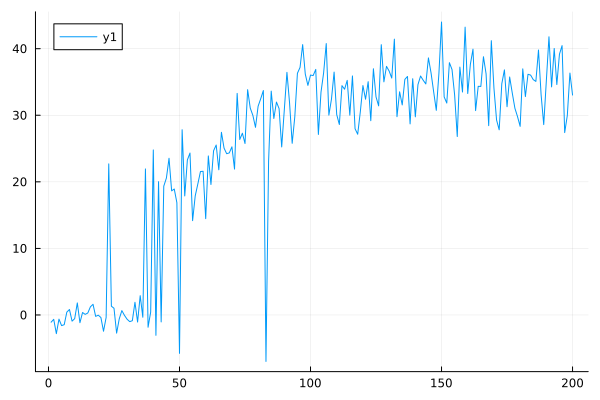

In [31]:
if TRAINING
    plot(episode_test_reward_hook.rewards)
end

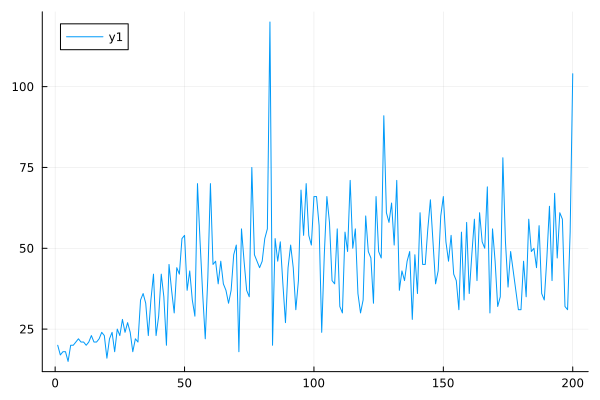

In [32]:
if TRAINING
    plot(episode_test_step_hook.steps[1:2:end])
end

In [33]:
close_visualization(); # closes the MeshCat visualization

In [34]:
# Question: realtime is super fast , thrust wird sehr groß visuell
# 

# Evaluation

In [35]:
test_env = VtolEnv(;name = "test_cf");

In [36]:
function loadModel(path, num)
    f = joinpath(path, "cf_ppo_$num.bson") 
    @load f model
    return model
end;

In [37]:
function validate(num_models, num_test)
    episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
    # create a env only for reward test
    #todo evtl mit multithreding
    for i in 1:num_models
          
        sum_rewards_model = 0;
        sum_successes_model = 0;
        sum_avg_vel_model = 0;
        sum_compl_time = 0;
        n_success = 0;
        
        for exp in 1:num_test
            if SLOW_MODE
                path = "./RL_models_slow/"
            else
                path = "./RL_models_fast/"
            end
            agent.policy.approximator = loadModel(path, i * save_freq); 
            RLBase.reset!(test_env)
            run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
            # the result of the hook
            sum_rewards_model += episode_test_reward_hook.rewards[end];
            
            if test_env.reached_goal == trues(test_env.num_waypoints)
                n_success += 1
                sum_avg_vel_model += test_env.norm_way / test_env.t
                sum_compl_time += test_env.t
            end
        end
        
        rewards[i] = sum_rewards_model / num_test;
        success_rate[i] = n_success / num_test;
        if n_success > 0
            avg_velocity[i] = sum_avg_vel_model / n_success;
            avg_compl_time[i] = sum_compl_time / n_success;
        else
            avg_velocity[i] = NaN
            avg_compl_time[i] = NaN
        end
        percent = percent = round(i * 100 / num_models, digits=2)
        print("progress: $(percent)%   \r")
        flush(stdout)
        
    end
    
    
end;

In [38]:
EVALUATION = true
if EVALUATION
    
    num_model = Int(steps / save_freq); 
    num_test = 200; # TODO: change as desired 

    rewards = zeros(num_model, 1);
    success_rate = zeros(num_model, 1);
    avg_velocity = zeros(num_model, 1);
    avg_compl_time = zeros(num_model, 1);

    validate(num_model, num_test);
    
    results_path = pwd() * "/plots/";
    if SLOW_MODE
        results_path = results_path * "slow/"
    else
        results_path = results_path * "fast/"
    end
    
    save(results_path * "iterations.jld", "data", [1:num_model] * save_freq) # todo save size auch in 2d
    
    save(results_path * "avg_comp_time.jld", "data", avg_compl_time)
    
    save(results_path * "avg_velocity.jld", "data", avg_velocity)
    
    save(results_path * "reward.jld", "data", rewards) 
        
    save(results_path * "success_rate.jld", "data", success_rate)
    
end;

In [39]:
results_path = pwd() * "/plots/";
if SLOW_MODE
    results_path = results_path * "slow/"
else
    results_path = results_path * "fast/"
end

iterations = load(results_path * "iterations.jld")["data"];
avg_compl_time = load(results_path * "avg_comp_time.jld")["data"];
avg_velocity = load(results_path * "avg_velocity.jld")["data"];
rewards = load(results_path * "reward.jld")["data"];
success_rate = load(results_path * "success_rate.jld")["data"];

In [40]:
fig_path = pwd() * "/plots/";
if SLOW_MODE
    fig_path = fig_path * "slow/"
else
    fig_path = fig_path * "fast/"
end

"/home/larissa/Documents/Projects/ADLR/ADLR_project/src/3d/plots/slow/"

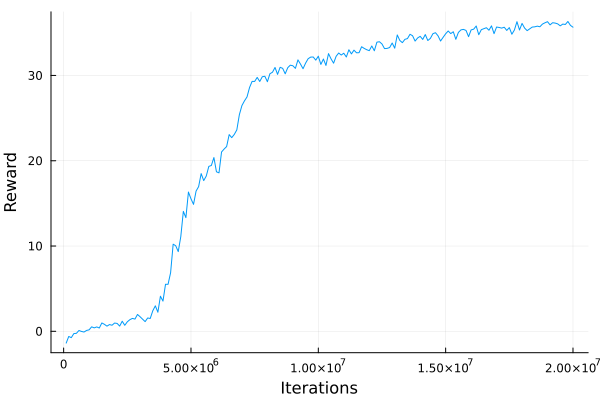

In [41]:
plot(iterations, rewards, xlabel="Iterations", ylabel="Reward", legend = false, xformatter = :scientific)

In [42]:
savefig(fig_path * "reward.svg")

"/home/larissa/Documents/Projects/ADLR/ADLR_project/src/3d/plots/slow/reward.svg"

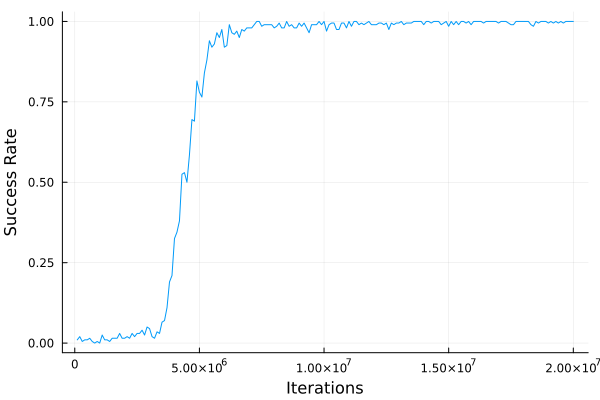

In [43]:
plot(iterations, success_rate, xlabel="Iterations", ylabel="Success Rate", legend = false, xformatter = :scientific)

In [44]:
savefig(fig_path * "success_rate.svg")

"/home/larissa/Documents/Projects/ADLR/ADLR_project/src/3d/plots/slow/success_rate.svg"

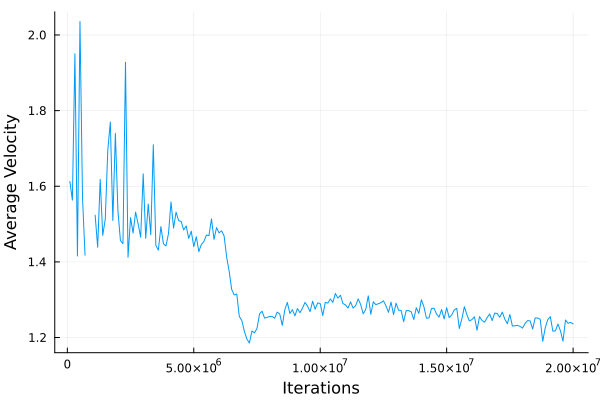

In [45]:
plot(iterations, avg_velocity, xlabel="Iterations", ylabel="Average Velocity", legend = false, xformatter = :scientific)

In [46]:
savefig(fig_path * "avg_velocity.svg")

"/home/larissa/Documents/Projects/ADLR/ADLR_project/src/3d/plots/slow/avg_velocity.svg"

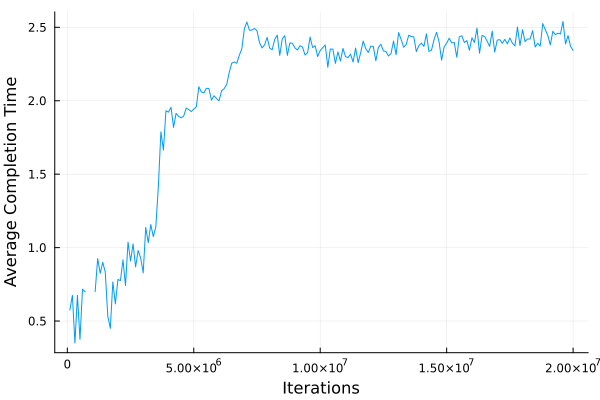

In [47]:
plot(iterations, avg_compl_time, xlabel="Iterations", ylabel="Average Completion Time", legend = false, xformatter = :scientific)

In [48]:
savefig(fig_path * "avg_comp_time.svg")

"/home/larissa/Documents/Projects/ADLR/ADLR_project/src/3d/plots/slow/avg_comp_time.svg"

# Create Videos

In [49]:
create_visualization();

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8701


In [50]:
# TODO: load_model as desired
vid_env = VtolEnv(;name = "testVTOL", visualization = true, realtime = true);

if SLOW_MODE
    path = "./RL_models_slow/"
    load_model = 500_000
    println("slow mode")
else
    path = "./RL_models_fast/"
    load_model = 1_250_000
    println("fast mode")
end
agent.policy.approximator = loadModel(path,load_model); 
RLBase.reset!(vid_env)
run(agent.policy, vid_env, StopAfterEpisode(2))

slow mode


EmptyHook()

In [51]:
close_visualization();

done